<a href="https://colab.research.google.com/github/sharma18b/Image-Captioning/blob/main/VGG16_%2B_LSTM_bahdanau_attention_on_Flickr30k_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/'

In [2]:
!kaggle datasets download -d 'hsankesara/flickr-image-dataset'

100% 8.16G/8.16G [02:57<00:00, 48.2MB/s]
100% 8.16G/8.16G [02:57<00:00, 49.3MB/s]


In [3]:
!unzip  flickr-image-dataset

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5362687336.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

In [4]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [5]:
# Download caption annotation files
annotation_folder = '/flickr30k_images/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/flickr30k_images/flickr30k_images/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

In [6]:
dir_Flickr_text = "/content/flickr30k_images/results.csv"

In [7]:
import pandas as pd

In [15]:
annotation_file = os.path.abspath('.') + annotation_folder + 'results.csv'
file = open(annotation_file,'r')
text = file.read()
file.close()
#df_bonus = pd.read_csv(annotation_file)

In [25]:
df = pd.read_csv('/content/flickr30k_images/results.csv',
                   sep = '|',
                   engine = 'python')

In [51]:
colx = list()
for col in df.columns:
  colx.append(col);
  print(col)

image_name
 comment_number
 comment


In [53]:
print(colx[:3])

['image_name', ' comment_number', ' comment']


In [34]:
total_captions_in_f30k = len(df['image_name'])
print(total_captions_in_f30k)

158915


In [38]:
print(df['comment'][0])

1000092795.jpg


In [55]:
image_path_to_caption = collections.defaultdict(list)
for val in range(total_captions_in_f30k):
  caption = f"<start> {df[' comment'][val]} <end>"
  image_path = PATH + df['image_name'][val]
  image_path_to_caption[image_path].append(caption)

In [56]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:30000]
print(len(train_image_paths))

30000


In [57]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start>  Two people are standing on the slopes of a mountain and they have a dog with them . <end>


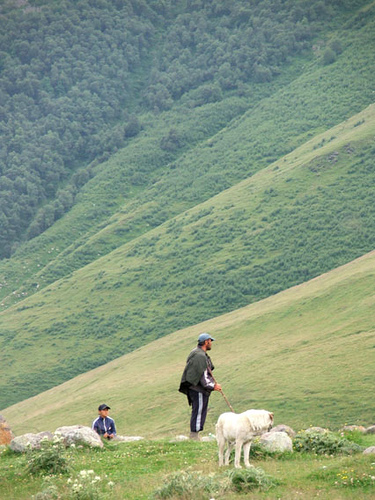

In [58]:
print(train_captions[0])
Image.open(img_name_vector[0])

In [59]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [61]:

image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
____________________________________________________________

In [62]:
from tqdm import tqdm
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 1875/1875 [13:22<00:00,  2.34it/s]


In [63]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [64]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [65]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


In [67]:
print(train_captions[:3])
print(train_seqs[:3])

['<start>  Two people are standing on the slopes of a mountain and they have a dog with them . <end>', '<start>  A man , his little son and their dog going for a walk in the mountains . <end>', '<start>  Two men and a white dog stand in a meadow near a steep hill . <end>']
[[3, 14, 17, 15, 34, 7, 6, 3838, 11, 2, 241, 8, 254, 380, 2, 33, 12, 147, 4], [3, 2, 9, 26, 54, 743, 8, 64, 33, 351, 53, 2, 149, 5, 6, 450, 4], [3, 14, 31, 8, 2, 22, 33, 107, 5, 2, 2326, 81, 2, 1156, 287, 4]]


In [66]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

#Splitting 

In [68]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [69]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(120000, 120000, 30000, 30000)

In [70]:
print('image _ name _ train ' )
print(img_name_train[0:3])
print('cap _ train ' )
print(cap_train[0:3])
print('image _ name _ val ' )
print(img_name_val[0:3])
print('cap _ train ' )
print(cap_val[0:3])

image _ name _ train 
['/content/flickr30k_images/flickr30k_images/3414155880.jpg', '/content/flickr30k_images/flickr30k_images/3414155880.jpg', '/content/flickr30k_images/flickr30k_images/3414155880.jpg']
cap _ train 
[array([   3,   14,   17,  380, 3730,   16,    6,  101,   11,    2,  572,
         25,   43,    9,    5,   27,   84,   88,    6,  180,  572,    4,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32), array([   3,  377,  220, 1181, 3016,   16, 1749,   73,    2, 3908, 4593,
         52,    2,   28,  377,  143,  938,   46,    4,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          

In [71]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49


# BATCH_SIZE = 64
# BUFFER_SIZE = 1000
# embedding_dim = 256
# units = 512
# vocab_size = top_k + 1
# num_steps = len(img_name_train) // BATCH_SIZE
# # Shape of the vector extracted from InceptionV3 is (64, 2048)
# # These two variables represent that vector shape
# features_shape = 2048
# attention_features_shape = 64

In [72]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [73]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

#Model Design 

In [74]:
class VGG16_Encoder(tf.keras.Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(VGG16_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x   

In [75]:
def rnn_type(units):
   if True:
       return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
   else:
       return tf.keras.layers.GRU(units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_activation='sigmoid',
                                  recurrent_initializer='glorot_uniform')

In [76]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(tf.keras.Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
   self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  
   self.fc1 = tf.keras.layers.Dense(self.units)

   self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = tf.keras.layers.Dense(vocab_size)

   # Implementing Attention Mechanism
   self.Uattn = tf.keras.layers.Dense(units)
   self.Wattn = tf.keras.layers.Dense(units)
   self.Vattn = tf.keras.layers.Dense(1)

 def call(self, x, features, hidden):
   # features shape ==> (64,49,256) ==> Output from ENCODER
   # hidden shape == (batch_size, hidden_size) ==>(64,512)
   # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

   hidden_with_time_axis = tf.expand_dims(hidden, 1)

   # score shape == (64, 49, 1)
   # Attention Function
   '''e(ij) = f(s(t-1),h(j))'''
   ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

   # self.Uattn(features) : (64,49,512)
   # self.Wattn(hidden_with_time_axis) : (64,1,512)
   # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
   # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

   # you get 1 at the last axis because you are applying score to self.Vattn
   # Then find Probability using Softmax
   '''attention_weights(alpha(ij)) = softmax(e(ij))'''

   attention_weights = tf.nn.softmax(score, axis=1)

   # attention_weights shape == (64, 49, 1)
   # Give weights to the different pixels in the image
   ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''

   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)

   # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
   # context_vector shape after sum == (64, 256)
   # x shape after passing through embedding == (64, 1, 256)

   x = self.embedding(x)
   # x shape after concatenation == (64, 1,  512)

   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
   # passing the concatenated vector to the GRU

   output, state = self.gru(x)
   # shape == (batch_size, max_length, hidden_size)

   x = self.fc1(output)
   # x shape == (batch_size * max_length, hidden_size)

   x = tf.reshape(x, (-1, x.shape[2]))

   # Adding Dropout and BatchNorm Layers
   x= self.dropout(x)
   x= self.batchnormalization(x)

   # output shape == (64 * 512)
   x = self.fc2(x)

   # shape : (64 * 8329(vocab))
   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))


encoder = VGG16_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)


In [77]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

In [78]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [79]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

#Training

In [80]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [81]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.6262
Epoch 1 Batch 100 Loss 0.8944
Epoch 1 Batch 200 Loss 0.7272
Epoch 1 Batch 300 Loss 0.6693
Epoch 1 Batch 400 Loss 0.6972
Epoch 1 Batch 500 Loss 0.7174
Epoch 1 Batch 600 Loss 0.6096
Epoch 1 Batch 700 Loss 0.6165
Epoch 1 Batch 800 Loss 0.6097
Epoch 1 Batch 900 Loss 0.5613
Epoch 1 Batch 1000 Loss 0.6299
Epoch 1 Batch 1100 Loss 0.5848
Epoch 1 Batch 1200 Loss 0.5301
Epoch 1 Batch 1300 Loss 0.6592
Epoch 1 Batch 1400 Loss 0.6130
Epoch 1 Batch 1500 Loss 0.5902
Epoch 1 Batch 1600 Loss 0.6082
Epoch 1 Batch 1700 Loss 0.5661
Epoch 1 Batch 1800 Loss 0.5877
Epoch 1 Loss 0.648584
Time taken for 1 epoch 2060.70 sec

Epoch 2 Batch 0 Loss 0.6561
Epoch 2 Batch 100 Loss 0.5488
Epoch 2 Batch 200 Loss 0.5592
Epoch 2 Batch 300 Loss 0.5816
Epoch 2 Batch 400 Loss 0.5600
Epoch 2 Batch 500 Loss 0.6262
Epoch 2 Batch 600 Loss 0.5287
Epoch 2 Batch 700 Loss 0.4944
Epoch 2 Batch 800 Loss 0.5101
Epoch 2 Batch 900 Loss 0.5584
Epoch 2 Batch 1000 Loss 0.5985
Epoch 2 Batch 1100 Loss 0.5442
Epoch

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a garden in the back with a pizza oven <end>
Prediction Caption: the statue of a brown building area with a clock in a room <end>


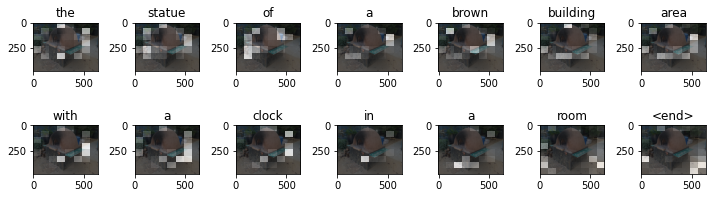

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [ ]:
decoder.save_weights('decoder.h5')
encoder.save_weights('encoder.h5')
image_features_extract_model.save_weights('image_features_extract_model.h5')


In [ ]:
from google.colab import files
files.download('/content/decoder.h5')
files.download('/content/encoder.h5')
files.download('/content/image_features_extract_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:

my_model_captions = dict()
for z in tqdm(range(5000)): # set higher to see more examples
  #plt.imshow(x)
  #plt.show()
  result, attention_plot = evaluate(image_paths[30000 + z])
  #p = generateCaption(image)
  my_model_captions[image_paths[30000 + z][34:]] = result
  #print("Caption:",generateCaption(image))
  #print("_____________________________________")



100%|██████████| 5000/5000 [25:11<00:00,  3.31it/s]


In [ ]:
given_captions = dict()
for z in tqdm(range(5000)): # set higher to see more examples
  #plt.imshow(x)
  #plt.show()
  result = image_path_to_caption[image_paths[30000 + z]]
  #p = generateCaption(image)
  given_captions[image_paths[30000 + z][34:]] = result

100%|██████████| 5000/5000 [00:00<00:00, 501651.00it/s]


In [ ]:
import pickle
a_file = open("my_gen_cap.pkl", "wb")
pickle.dump(my_model_captions, a_file)
a_file.close()
b_file = open("given_cap.pkl", "wb")
pickle.dump(given_captions, b_file)
b_file.close()

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
act, predict = list(), list()
def evaluate_model():
  for key,value in my_model_captions.items():
    pred = my_model_captions[key];
    ref = given_captions[key];
    references = [d.split() for d in ref];
    act.append(references);
    predict.append(pred);
  print('BLEU-1: %f' % corpus_bleu(act, predict, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(act, predict, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(act, predict, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(act, predict, weights=(0.25, 0.25, 0.25, 0.25)))
  

In [ ]:
evaluate_model()

BLEU-1: 0.465335
BLEU-2: 0.241488
BLEU-3: 0.155587
BLEU-4: 0.067110


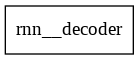

In [ ]:
dot_img_file = '/content/model_1.png'
tf.keras.utils.plot_model(decoder, to_file=dot_img_file, show_shapes=True)

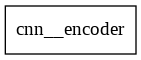

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(encoder, to_file='model_plot_encoder.png', show_shapes=True, show_layer_names=True)

In [ ]:
encoder.summary()

Model: "cnn__encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  524544    
Total params: 524,544
Trainable params: 524,544
Non-trainable params: 0
_________________________________________________________________


In [ ]:
decoder.summary()

Model: "rnn__decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1280256   
_________________________________________________________________
gru (GRU)                    multiple                  1575936   
_________________________________________________________________
dense_1 (Dense)              multiple                  262656    
_________________________________________________________________
dense_2 (Dense)              multiple                  2565513   
_________________________________________________________________
bahdanau_attention (Bahdanau multiple                  394753    
Total params: 6,079,114
Trainable params: 6,079,114
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plot_model(image_features_extract_model, to_file='model_plot_image.png', show_shapes=True, show_layer_names=True)